# QAOA Implementation to solve QUBO in Pennylane
**See 'QAOA_CudaQ.ipynb' first**

In [4]:
!pip install pennylane

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 KB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.5 MB/s eta 0:00:00a 0:00:01


# Imports 
from `__init__.py`


In [33]:
from src_pennylane.utils import (
    nth_largest,
    check_first_five_bits
)

from src_pennylane.qaoa_converter import(
    Q_to_Ising,
    create_cost_Hamiltonian,
    create_mixer_Hamiltonian
)

from src_pennylane.circuits import (
    qaoa_layer,
    qaoa_layer_custom,
    circuit,
    circuit_custom,
    cost_function,
    cost_function_custom,
    prob_populations,
    prob_populations_custom,
    calculate_cost
)

from src_pennylane.optimizer import(
    run_qaoa_custom_opt,
    run_qaoa_opt
)

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# QUBO Problem

In [24]:
Q = np.array([
    [-180329,  28009,   63588,   69151,   34198,   -984,   -1967,   -3935,   -7870,  -15739,  -31478],
    [      0, -110296,  36811,   40032,   19798,   -569,   -1139,   -2278,   -4556,   -9111,  -18223],
    [      0,       0, -226999,  90883,   44946,   -1293,  -2586,   -5171,  -10343,  -20685,  -41371],
    [      0,       0,       0, -242882,   48878,  -1406,  -2812,   -5624,  -11248,  -22495,  -44990],
    [      0,       0,       0,       0, -132474,   -695,  -1391,   -2781,   -5562,  -11125,  -22250],
    [      0,       0,       0,       0,       0,   4169,     40,      80,     160,     320,     640],
    [      0,       0,       0,       0,       0,       0,   8358,    160,     320,     640,    1280],
    [      0,       0,       0,       0,       0,       0,      0,  16796,     640,    1280,    2560],
    [      0,       0,       0,       0,       0,       0,      0,      0,   33912,    2560,    5120],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,   69104,   10240],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,       0,  143329]
])

# Build Hamiltonians
wires = len(Q)
cost_Hamiltonian, offset, coeff_max = create_cost_Hamiltonian(Q)
mixer_hamiltonian = create_mixer_Hamiltonian(wires)
H_C = qml.Hamiltonian((1 / max(cost_Hamiltonian.coeffs)) * np.array(cost_Hamiltonian.coeffs), cost_Hamiltonian.ops)
print(f"cost_hamiltonian:{cost_hamiltonian}")
print("\n")
print(f"H_C:{H_C}")
print("\n")
print(f"coeff_max:{coeff_max}, offset = {offset}, offset normalized = {offset / coeff_max}")
offset /= coeff_max

cost_hamiltonian:56921.25 * Z(0) + 32954.5 * Z(1) + 74804.75 * Z(2) + 81348.75 * Z(3) + 40233.0 * Z(4) + -1157.75 * Z(5) + -2315.25 * Z(6) + -4630.75 * Z(7) + -9261.25 * Z(8) + -18523.25 * Z(9) + -37046.5 * Z(10) + 7002.25 * (Z(0) @ Z(1)) + 15897.0 * (Z(0) @ Z(2)) + 17287.75 * (Z(0) @ Z(3)) + 8549.5 * (Z(0) @ Z(4)) + -246.0 * (Z(0) @ Z(5)) + -491.75 * (Z(0) @ Z(6)) + -983.75 * (Z(0) @ Z(7)) + -1967.5 * (Z(0) @ Z(8)) + -3934.75 * (Z(0) @ Z(9)) + -7869.5 * (Z(0) @ Z(10)) + 9202.75 * (Z(1) @ Z(2)) + 10008.0 * (Z(1) @ Z(3)) + 4949.5 * (Z(1) @ Z(4)) + -142.25 * (Z(1) @ Z(5)) + -284.75 * (Z(1) @ Z(6)) + -569.5 * (Z(1) @ Z(7)) + -1139.0 * (Z(1) @ Z(8)) + -2277.75 * (Z(1) @ Z(9)) + -4555.75 * (Z(1) @ Z(10)) + 22720.75 * (Z(2) @ Z(3)) + 11236.5 * (Z(2) @ Z(4)) + -323.25 * (Z(2) @ Z(5)) + -646.5 * (Z(2) @ Z(6)) + -1292.75 * (Z(2) @ Z(7)) + -2585.75 * (Z(2) @ Z(8)) + -5171.25 * (Z(2) @ Z(9)) + -10342.75 * (Z(2) @ Z(10)) + 12219.5 * (Z(3) @ Z(4)) + -351.5 * (Z(3) @ Z(5)) + -703.0 * (Z(3) @ Z(6)) +

In [23]:
# Known minimum value.

optimum_known = calculate_cost("11110101000",Q)
print(f"optimum_known = {optimum_known}")
optimum_known = float(optimum_known) / coeff_max
print(f"optimum_known renoarmlized = {optimum_known}")

optimum_known = -432247
optimum_known renoarmlized = -5.313505124540942


# QAOA Implementation
- circuit depth ($p$) = 10
- qubits used = 11
- #. of iterations in the optimizer = 200
    - This is slightly greater than that was for CudaQ + FOURIER heuristics, but it was not the number of iterations that limited the approximate ratio anyways
-  #. of parameters to optimize (FOURIER_amplitude) = $2p$ or $4p$ (when 'custom')


# QAOA Linear Schedule Evaluation (No Optimization)
We first construct the cost and mixer Hamiltonians from the QUBO matrix, apply **a simple linear schedule for the parameters** to mimic the **adiabatic** time depedence of a Hamiltonian, and analyze the output probabilities and configurations without any optimization. Start from $\beta_0 = 1$ and $\gamma_0 = 0$. Then gradually decrease/increase $\beta / \gamma$, for the ground state of the cost function to be reached adibatically at the end of the algorithm.

> Note: <br>
> Although with the number of steps converging to infinity, this adiabatic QAOA must be exact. in practice this does not happen due to rounding errors from each step.


In [14]:
# Linear schedules
depth = 10
gammas = np.linspace(1, 0, depth, endpoint=False)[::-1]
betas = np.linspace(0.8, 0, depth)
parameters = [gammas, betas]

# Pennylane device
device = qml.device("default.qubit", wires=wires)


In [26]:
# Run the cost function (expectation value)
cost = cost_function(
    parameters, depth, H_C, cost_hamiltonian, mixer_hamiltonian, wires, device, normalized=True
)
print(f"\n✅ Expectation value of the cost function: {cost + offset}  approximation ratio: {100*(cost + offset)/optimum_known}%")



✅ Expectation value of the cost function: -5.174472605640425  approximation ratio: 97.38341234944177%


## Observation on QAOA Performance

Interestingly, for this particular QUBO problem instance, the **linear parameter schedule** in PennyLane (mimicking adiabatic evolution) achieves a **better cost value** than the fully optimized Fourier-heuristic QAOA implemented in CUDA-Q.

This suggests that the parameter landscape for this problem is **extremely flat**, with the global minimum likely residing in a **narrow basin** that the Fourier-based ansatz failed to explore effectively. 

In such cases:
- The Fourier heuristic, designed under the assumption of smooth parameter variation, might need higher order terms to achieve linear behaviour.
- The global optimum, or even high-quality local minima, are **not ao accessible** through Fourier-structured parameters.

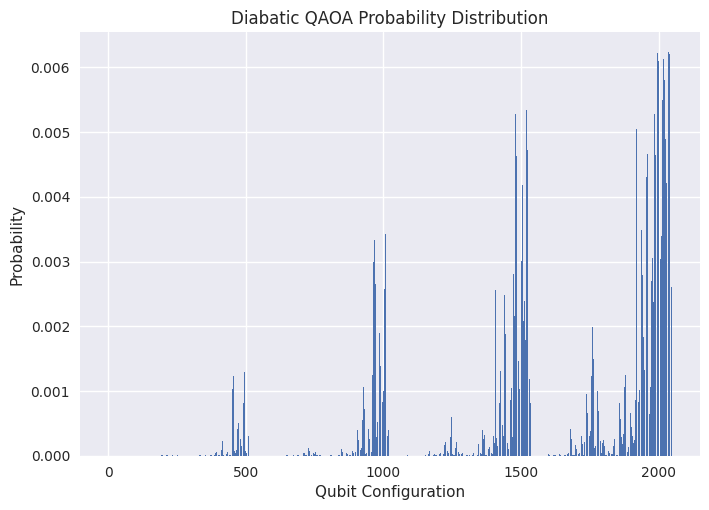


Non-zero states: 2048

🔝 Top 3 lowest-cost configurations:
Config: 11110001000, Cost: -432244, Prob: 0.47378620%
Config: 10111110100, Cost: -432238, Prob: 0.47218244%
Config: 11110101000, Cost: -432247, Prob: 0.46547592%

🎯 Probability of matching first five bits: 16.0960%


In [30]:
# Get full probability distribution
probs = prob_populations(
    parameters, depth, H_C, mixer_hamiltonian, wires, device
)

# Plot probability distribution
plt.style.use('seaborn-v0_8')
plt.bar(range(2**wires), probs)
plt.xlabel("Qubit Configuration")
plt.ylabel("Probability")
plt.title("Diabatic QAOA Probability Distribution")
plt.show()

# Analyze probabilities
count = np.count_nonzero(probs)
print(f"\nNon-zero states: {count}")

indices = np.where(probs >= nth_largest(probs, count))[0]
indices = indices[np.argsort(probs[indices])[::-1]]

binary_indices = [np.binary_repr(i, width=wires) for i in indices]
costs = np.array([calculate_cost(b,Q) for b in binary_indices])

# Get top 3 lowest-cost configurations
threshold = -nth_largest(-costs, 3)
final_mask = costs <= threshold

final_configs = np.array(binary_indices)[final_mask]
final_costs = costs[final_mask]
final_probs = probs[indices[final_mask].astype(int)]

print("\n🔝 Top 3 lowest-cost configurations:")
for config, config_cost, prob in zip(final_configs, final_costs, final_probs):
    print(f"Config: {config}, Cost: {config_cost}, Prob: {100 * prob:.8f}%")

# Probability of getting the correct value (first five bits match)
total_prob = 0
for idx, prob in enumerate(probs):
    if check_first_five_bits(idx, total_bits=wires):
        total_prob += prob

print(f"\n🎯 Probability of matching first five bits: {100 * total_prob:.4f}%")

# QAOA With Optimization

Rather than mimicing adiabatic Quantum Annealing from the Trotterized gates, let us now employ the classical optimizer.

Step 0: Cost = -3.6657799360070884
Step 10: Cost = -5.1340508163230405
Step 20: Cost = -5.209858369698855
Step 30: Cost = -5.258827491074103
Step 40: Cost = -5.262831265191696
Step 50: Cost = -5.266789110340802
Step 60: Cost = -5.271578573888389
Step 70: Cost = -5.273874491499335
Step 80: Cost = -5.275330209515035
Step 90: Cost = -5.276518295631487
Step 100: Cost = -5.2774158196363645
Step 110: Cost = -5.278243705208054
Step 120: Cost = -5.278955345194431
Step 130: Cost = -5.279598163388555
Step 140: Cost = -5.28020821650796

✅ Optimized cost (normalized): -5.28074503056025
✅ Approximation ratio: 99.38%


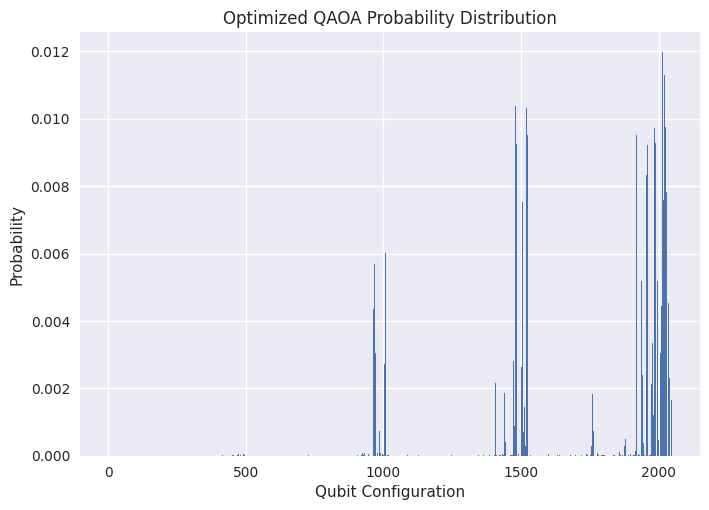


Non-zero states: 2048

🔝 Top 3 lowest-cost configurations:
Config: 10111110100, Cost: -432238, Prob: 0.95275447%
Config: 11110001000, Cost: -432244, Prob: 0.93665489%
Config: 11110101000, Cost: -432247, Prob: 0.92295024%

🎯 Probability of matching first five bits: 19.4656%


In [39]:
# --- Optimization Setup ---

depth = 10
steps = 150
stepsize = 0.2

# Initialize parameters (heuristic linear schedules)
gammas = np.linspace(1, 0, depth, endpoint=False)[::-1]
betas = np.linspace(0.8, 0, depth)
parameters = np.array([gammas, betas], requires_grad=True)

# Setup optimizer
optimizer = qml.AdamOptimizer(stepsize=stepsize)

# --- Optimization Loop ---
for i in range(steps):
    parameters = optimizer.step(
        lambda p: cost_function(p, depth, H_C, cost_hamiltonian, mixer_hamiltonian, wires, device, normalized=True),
        parameters
    )
    if i % 10 == 0:
        current_cost = cost_function(parameters, depth, H_C, cost_hamiltonian, mixer_hamiltonian, wires, device, normalized=True)+offset
        print(f"Step {i}: Cost = {current_cost}")

# Final optimized cost
final_cost = cost_function(parameters, depth, H_C, cost_hamiltonian, mixer_hamiltonian, wires, device, normalized=True) + offset
print(f"\n✅ Optimized cost (normalized): {final_cost}")
print(f"✅ Approximation ratio: {100 * final_cost  / optimum_known:.2f}%")

# --- Probability Distribution ---

probs = prob_populations(parameters, depth, H_C, mixer_hamiltonian, wires, device)

plt.style.use('seaborn-v0_8')
plt.bar(range(2**wires), probs)
plt.xlabel("Qubit Configuration")
plt.ylabel("Probability")
plt.title("Optimized QAOA Probability Distribution")
plt.show()

# --- Analysis of Probabilities ---

count = np.count_nonzero(probs)
print(f"\nNon-zero states: {count}")

indices = np.where(probs >= nth_largest(probs, count))[0]
indices = indices[np.argsort(probs[indices])[::-1]]

binary_indices = [np.binary_repr(i, width=wires) for i in indices]
costs = np.array([calculate_cost(b, Q) for b in binary_indices])

# Get top 3 lowest-cost configurations
threshold = -nth_largest(-costs, 3)
final_mask = costs <= threshold

final_configs = np.array(binary_indices)[final_mask]
final_costs = costs[final_mask]
final_probs = probs[indices[final_mask].astype(int)]

print("\n🔝 Top 3 lowest-cost configurations:")
for config, config_cost, prob in zip(final_configs, final_costs, final_probs):
    print(f"Config: {config}, Cost: {config_cost}, Prob: {100 * prob:.8f}%")

# Probability of getting the correct value (first five bits match)
total_prob = 0
for idx, prob in enumerate(probs):
    if check_first_five_bits(idx, total_bits=wires):
        total_prob += prob

print(f"\n🎯 Probability of matching first five bits: {100 * total_prob:.4f}%")

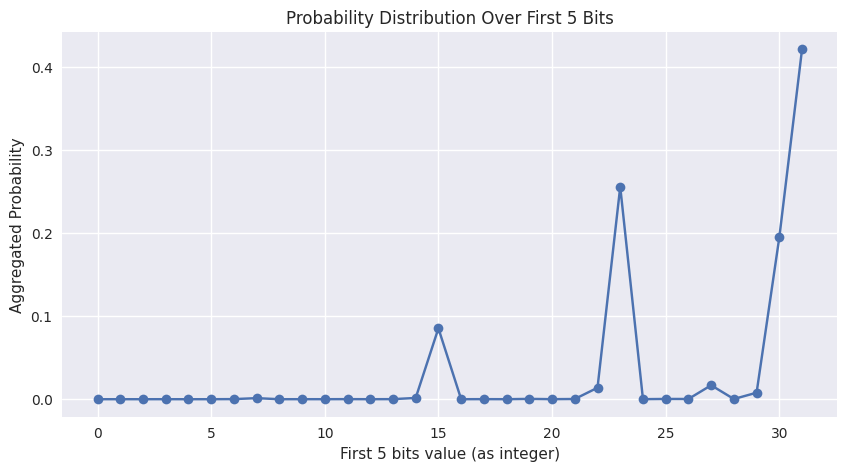


 Probability of the correct minimum (11110 = 30): 19.4656%
 Most probable value: 11111 with probability 42.0869%


In [35]:
# Calculate aggregated probabilities over the first 5 bits
five_bits_probs = defaultdict(float)

for index, prob in enumerate(probs):
    # Group by first 5 bits
    key = index // 2**(wires - 5)
    five_bits_probs[key] += prob

# Plot the probabilities
plt.figure(figsize=(10, 5))
plt.plot(list(five_bits_probs.keys()), list(five_bits_probs.values()), marker='o')
plt.xlabel("First 5 bits value (as integer)")
plt.ylabel("Aggregated Probability")
plt.title("Probability Distribution Over First 5 Bits")
plt.grid(True)
plt.show()

# Get max value info
values_list = list(five_bits_probs.values())
max_index = values_list.index(max(values_list))
max_key = list(five_bits_probs.keys())[max_index]

print(f"\n Probability of the correct minimum (11110 = 30): {100 * five_bits_probs[30]:.4f}%")
print(f" Most probable value: {np.binary_repr(max_key, width=5)} with probability {100 * five_bits_probs[max_key]:.4f}%")


## Custom Mixer Layer  

Introducing variational parameters through a tunable mixer Hamiltonian, which shares the same spirit to multi-angle QAOA (ma-QAOA) but with much fewer parameters independent of the number of qubits. Seems to help accelerate the convergence of the optimizer, but not verified.

With the Hamiltonians 
* $H_C (\gamma_k) = \gamma_k(\sum_ih_iZ_i + \sum_{i,j}Z_iZ_j )$,
* $H_M (\beta_k)= \beta_k(aX + bZ))$

this is a blend of QAOA with quantum annealing, which is often called the analog quantum computation, while QAOA is gated-based, digital quantum computation. By having a non-Pauli mixer term (arguable to be digital quantum computing, but would generally be an easy thing to carry out on QPU e.g. applying uniform strength of magnetic field across qubits, which changes the values with in a discrete manner from an interval to another ), while maintaining the non-commutative relation with the cost Hamiltonian, by optimizing these parameters well, the adiabaticity could be achieved faster (i.e. easier to find Shortcut-to-Adiabaticity). 

Step 0: Cost = -3.0572355208981294
Step 10: Cost = -5.1222019302190365
Step 20: Cost = -5.229233092637041
Step 30: Cost = -5.243756933096816
Step 40: Cost = -5.260375783114246
Step 50: Cost = -5.267954655375526
Step 60: Cost = -5.271825630239906
Step 70: Cost = -5.273665204010294
Step 80: Cost = -5.274874274082393
Step 90: Cost = -5.277898060044691
Step 100: Cost = -5.279359559604316
Step 110: Cost = -5.280021891802006
Step 120: Cost = -5.269259209491443
Step 130: Cost = -5.274310443618834
Step 140: Cost = -5.272413172417997
Step 150: Cost = -5.270645337933735
Step 160: Cost = -5.273215181158692
Step 170: Cost = -5.277996141396182
Step 180: Cost = -5.281263664779791
Step 190: Cost = -5.281086637573001

✅ Final cost = -5.281605771685275
✅ Approximation ratio = 99.40% of the optimal value.


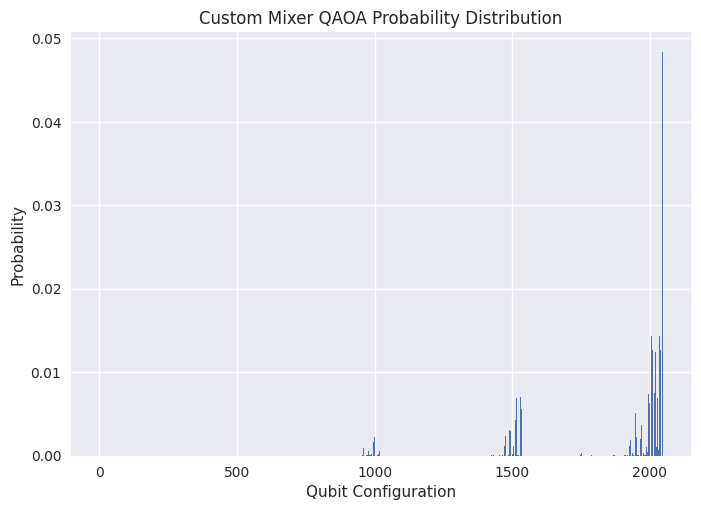


Non-zero states: 2048

🔝 Top 3 lowest-cost configurations:
Config: 10111110100, Cost: -432238, Prob: 0.72666405%
Config: 11110101000, Cost: -432247, Prob: 0.40085818%
Config: 11110001000, Cost: -432244, Prob: 0.22638397%

🎯 Probability of matching first five bits: 10.6635%


In [38]:
# --- Custom Mixer QAOA Optimization ---

depth = 10
steps = 200
stepsize = 0.2
wires = Q.shape[0]

# Initialize parameters (heuristic schedules)
gammas = np.linspace(np.pi / 2, 0, depth, endpoint=False)[::-1]
betas = np.linspace(np.pi / 4, 0, depth)
a_params = np.linspace(1.5, 0, depth)
b_params = np.linspace(0, 0.8, depth)

# Stack parameters
params = np.array(np.vstack([gammas, betas, a_params, b_params]), requires_grad=True)

# Setup optimizer
optimizer = qml.AdamOptimizer(stepsize=stepsize)

# Optimization loop
for i in range(steps):
    params = optimizer.step(
        lambda p: cost_function_custom(p, depth, H_C, cost_hamiltonian, wires, device, normalized=True),
        params
    )
    if i % 10 == 0:
        current_cost = cost_function_custom(params, depth, H_C, cost_hamiltonian, wires, device, normalized=True) + offset
        print(f"Step {i}: Cost = {current_cost}")

# Final cost after optimization
QAOA_cost = cost_function_custom(params, depth, H_C, cost_hamiltonian, wires, device, normalized=True) + offset
print(f"\n✅ Final cost = {QAOA_cost}")
print(f"✅ Approximation ratio = {(100 * QAOA_cost /optimum_known):.2f}% of the optimal value.")

# --- Probability Distribution ---

probs = prob_populations_custom(params, depth, H_C, wires, device)

plt.style.use('seaborn-v0_8')
plt.bar(range(2**wires), probs)
plt.xlabel("Qubit Configuration")
plt.ylabel("Probability")
plt.title("Custom Mixer QAOA Probability Distribution")
plt.show()

# --- Analyze probabilities ---

count = np.count_nonzero(probs)
print(f"\nNon-zero states: {count}")

indices = np.where(probs >= nth_largest(probs, count))[0]
indices = indices[np.argsort(probs[indices])[::-1]]

binary_indices = [np.binary_repr(i, width=wires) for i in indices]
costs = np.array([calculate_cost(b, Q) for b in binary_indices])

# Get top 3 lowest-cost configurations
threshold = -nth_largest(-costs, 3)
final_mask = costs <= threshold

final_configs = np.array(binary_indices)[final_mask]
final_costs = costs[final_mask]
final_probs = probs[indices[final_mask].astype(int)]

print("\n🔝 Top 3 lowest-cost configurations:")
for config, config_cost, prob in zip(final_configs, final_costs, final_probs):
    print(f"Config: {config}, Cost: {config_cost}, Prob: {100 * prob:.8f}%")

# --- Probability of correct solution (matching first five bits) ---

total_prob = 0
for idx, prob in enumerate(probs):
    if check_first_five_bits(idx, total_bits=wires):
        total_prob += prob

print(f"\n🎯 Probability of matching first five bits: {100 * total_prob:.4f}%")


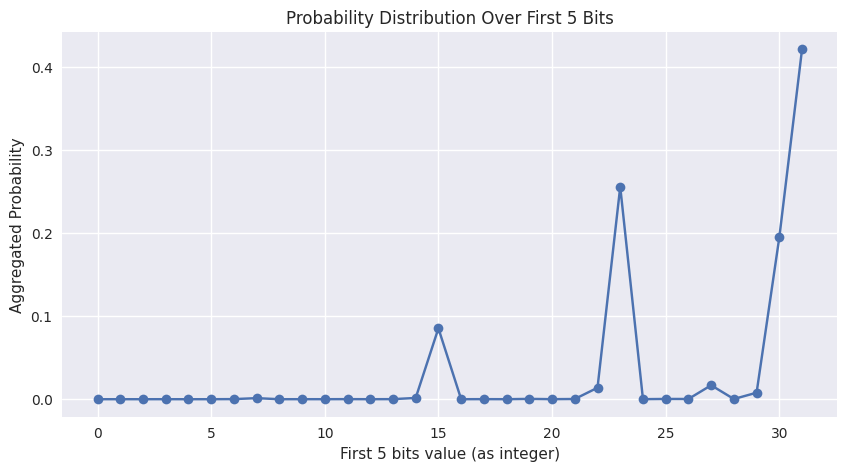


 Probability of the correct minimum (11110 = 30): 19.4656%
 Most probable value: 11111 with probability 42.0869%


In [40]:
# Calculate aggregated probabilities over the first 5 bits
five_bits_probs = defaultdict(float)

for index, prob in enumerate(probs):
    # Group by first 5 bits
    key = index // 2**(wires - 5)
    five_bits_probs[key] += prob

# Plot the probabilities
plt.figure(figsize=(10, 5))
plt.plot(list(five_bits_probs.keys()), list(five_bits_probs.values()), marker='o')
plt.xlabel("First 5 bits value (as integer)")
plt.ylabel("Aggregated Probability")
plt.title("Probability Distribution Over First 5 Bits")
plt.grid(True)
plt.show()

# Get max value info
values_list = list(five_bits_probs.values())
max_index = values_list.index(max(values_list))
max_key = list(five_bits_probs.keys())[max_index]

print(f"\n Probability of the correct minimum (11110 = 30): {100 * five_bits_probs[30]:.4f}%")
print(f" Most probable value: {np.binary_repr(max_key, width=5)} with probability {100 * five_bits_probs[max_key]:.4f}%")

# References

- Zhou et al. (2019). *Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*. [arXiv:1812.01041](https://arxiv.org/pdf/1812.01041)

- Institute and Faculty of Actuaries. *Asset Liability Modelling in the Quantum Era*. [Link](https://www.actuaries.org.uk/system/files/field/document/assetliability-modelling-in-the-quantum-era.%20to%20use.pdf)

- PennyLane. *Introduction to QAOA*. [Tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro)

- PennyLane. *Solving QUBO Problems with QAOA*. [Tutorial](https://pennylane.ai/qml/demos/tutorial_QUBO)

In [45]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import heapq
import collections

def print_versions():
    try:
        import cudaq
        print(f"cudaq version: {cudaq.__version__}")
    except ImportError:
        print("cudaq is not installed.")
    
    try:
        import pennylane as qml
        print(f"PennyLane version: {qml.__version__}")
    except ImportError:
        print("PennyLane is not installed.")
    
    print(f"numpy version: {np.__version__}")
    print(f"matplotlib version: {plt.matplotlib.__version__}")
    print(f"scipy version: {scipy.__version__}")
    
    # These are built-in, no versions
    print(f"heapq is built-in, no version.")
    print(f"collections is built-in, no version.")

print_versions()


cudaq version: CUDA-Q Version cu12-0.9.0 (https://github.com/NVIDIA/cuda-quantum 77a1c80a18896b4c7ff4ece99f06e6a62c8a28ef)
PennyLane version: 0.40.0
numpy version: 1.26.4
matplotlib version: 3.9.2
scipy version: 1.12.0
heapq is built-in, no version.
collections is built-in, no version.
